# Comparing the land cover classes across CCI, WorldCover and IO.  

In this notebook, we can get  
1. spatial maps (color-coded by classes),  
2. agreeement maps,  
3. distribution of total area per class,  
4. agreement vs. heterogeneity,  
5. land type transistion from CCI -> WorldCover/IO,  
6. distribution of agreement score.

In [ ]:
from pystac.client import Client
from odc.stac import load
import xarray as xr
from planetary_computer import sign_url
import rioxarray
import pandas as pd
import rasterio
from scipy.ndimage import uniform_filter

from odc.geo import BoundingBox
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import sys, os
sys.path.append(os.path.abspath(".."))
from src.spatial import list_countries, get_country_boundary
from src.Compare_LULC_func import *
from matplotlib_scalebar.scalebar import ScaleBar

In [4]:
# Personal choice to set ploting styles
plt.style.use('seaborn-v0_8-poster')
plt.rcParams['axes.grid'] = 'False'
plt.rcParams['grid.alpha'] = 0.3

In [5]:
# Use Planetary Computer STAC API
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1/")

# A generic function to load a product given the boundary
def load_lulc_data(product: str, resolution = 100):
    items = catalog.search(
        collections=[product],
        intersects=bbox.polygon,
        datetime="2020-06",
    ).item_collection()

    print(f"Found {len(items)} items for product {product}")

    ds = load(
        items,
        intersects=bbox.polygon,
        crs="EPSG:6933",
        groupby="solar_day",
        resolution=resolution,
        chunks={"x": 2048, "y": 2048},
        patch_url=sign_url,
        resample_alg="nearest",
    )

    print(f"Product {product} has variables: {ds.data_vars}")
    return ds

Read in boundary for the target country

In [6]:
country = list_countries()[25] #0, 5, 25, 28 are four samples in the report

gdf = get_country_boundary(country)
gdf

country_lat = gdf.geometry.centroid.iloc[0].y
country_lon = gdf.geometry.centroid.iloc[0].x
minx, miny, maxx, maxy = gdf.total_bounds
bounds = [[miny, minx], [maxy, maxx]]

bbox = BoundingBox(*(gdf.total_bounds), crs="EPSG:4326")
bbox.explore()

/var/folders/xb/_m7kb18x42x3s2_m6wb6kqj00000gn/T/ipykernel_90477/3611070845.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_lat = gdf.geometry.centroid.iloc[0].y
/var/folders/xb/_m7kb18x42x3s2_m6wb6kqj00000gn/T/ipykernel_90477/3611070845.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_lon = gdf.geometry.centroid.iloc[0].x


Load CCI-LC at 300m resolution

In [7]:
cci_da = load_lulc_data('esa-cci-lc', resolution=300)

vars = list(cci_da.data_vars)
cci_da["esa_cci_lc"] = cci_da["lccs_class"]
ds_tmp = cci_da.drop_vars(vars)
cci_da = ds_tmp.squeeze().load() # removes any singleton dimension and then load the full data

# Limit the product within the administrative boundary (mainly for removing the water body)
region_gdf = gdf.to_crs(epsg=6933)
data = cci_da.rio.write_crs("EPSG:6933")
geom = region_gdf.geometry.values
cci_da = data.rio.clip(geom, region_gdf.crs)

Found 1 items for product esa-cci-lc
Product esa-cci-lc has variables: Data variables:
    lccs_class           (time, y, x) uint8 120kB dask.array<chunksize=(1, 264, 453), meta=np.ndarray>
    change_count         (time, y, x) uint8 120kB dask.array<chunksize=(1, 264, 453), meta=np.ndarray>
    processed_flag       (time, y, x) uint8 120kB dask.array<chunksize=(1, 264, 453), meta=np.ndarray>
    observation_count    (time, y, x) uint16 239kB dask.array<chunksize=(1, 264, 453), meta=np.ndarray>
    current_pixel_state  (time, y, x) uint8 120kB dask.array<chunksize=(1, 264, 453), meta=np.ndarray>


Load WorldCover dataset at 10m resolution and reproject to CCI 300m grid

In [8]:
wc_da = load_lulc_data('esa-worldcover', resolution=10)

vars = list(wc_da.data_vars)
wc_da["esa_worldcover"] = wc_da["map"]
ds_tmp = wc_da.drop_vars(vars)
wc_da = ds_tmp.squeeze().load() #removes any singleton dimension and then load the full data

# Reproject WorldCover to match CCI resolution using majority vote
wc_300m = wc_da.rio.reproject_match(
    cci_da,
    resampling=rasterio.enums.Resampling.mode   # majority vote (the value that appears most often)
)

# Limit the product within the administrative boundary (mainly for removing the water body)
region_gdf = gdf.to_crs(epsg=6933)
data = wc_300m.rio.write_crs("EPSG:6933")
geom = region_gdf.geometry.values
wc_300m = data.rio.clip(geom, region_gdf.crs)

Found 1 items for product esa-worldcover
Product esa-worldcover has variables: Data variables:
    map              (time, y, x) uint8 107MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    input_quality.1  (time, y, x) int16 215MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    input_quality.2  (time, y, x) int16 215MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    input_quality.3  (time, y, x) int16 215MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>


/opt/anaconda3/envs/geo-env/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


Load IO LULC at 10m resolution and reproject to CCI 300m grid

In [9]:
io_da = load_lulc_data('io-lulc-annual-v02', resolution=10)

vars = list(io_da.data_vars)
io_da["io_lulc"] = io_da["data"]
ds_tmp = io_da.drop_vars(vars)
io_da = ds_tmp.squeeze().load() # removes any singleton dimension and then load the full data

# Reproject IO to match CCI resolution using majority vote
io_300m = io_da.rio.reproject_match(
    cci_da,
    resampling=rasterio.enums.Resampling.mode   # majority vote (the value that appears most often)
)

# Limit the product within the administrative boundary (mainly for removing the water body)
region_gdf = gdf.to_crs(epsg=6933)
data = io_300m.rio.write_crs("EPSG:6933")
geom = region_gdf.geometry.values
io_300m = data.rio.clip(geom, region_gdf.crs)

Found 1 items for product io-lulc-annual-v02
Product io-lulc-annual-v02 has variables: Data variables:
    data     (time, y, x) float32 429MB dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>


Standardise all land cover classes to UNCCD

In [10]:
# Define mapping dictionaries for each product
cci_lc_map = {
    10:3, 11:3, 12:3, 20:3, 30:3, #Cropland class -> Cropland
    40:2, 120:2, 121:2, 122:2,#Natural Vegetation -> Grassland, #Shrub class -> Grassland
    50:1, 60:1, 61:1, 62:1, 70:1, 71:1, 72:1, 80:1, 81:1, 82:1, 90:1, 100:1, #Tree class -> Tree, #Tree and shrub - > 1 Tree
    110:2, 130:2, 140:2, #Grass and Herbaceous -> Grassland, #Moss/lichen -> Grassland
    150:2, 151:2, 152:2, 153:2, #Sparse vegetation -> Grassland
    160:4, 170:4,180:4, #Wetland
    190:5, #Build up
    200:6, 201:6, 202:6, 220:6, #Bare class -> other land, #Snow/Ice -> other land
    210:7, #Water
}

world_cover_map = {
    80:7, #Water
    10:1, #Tree
    20:2, 30:2,#Shrub, Grassland -> Grassland
    40:3, #cropland
    50:5, #build up
    60:6, 70:6,#Bare, Snow/Ice -> other land
    90:4, 95:4,#Wetland, Mangroves -> Wetland
    100:6 #Moss/Lichen -> otherland
}

io_map = {
    0:0, #No data
    1:7, #Water
    2:1, #Tree
    4:4, #Wetland
    5:3, #Cropland
    7:5, #Build-up
    8:6, 9:6, 10:6,#Bare/Sparse, #Snow/Ice, #Cloud -> other land
    11:2 #Rangeland
}

In [11]:
cci_da['esa_cci_lc'] = standardise_class(cci_da['esa_cci_lc'], cci_lc_map)
wc_300m['esa_worldcover'] = standardise_class(wc_300m['esa_worldcover'], world_cover_map)
io_300m['io_lulc'] = standardise_class(io_300m['io_lulc'], io_map)

For Comoros, Antigua and Barbuda, and Samoa, we limit the analysis on the largest island

In [12]:
# Define bounds
if country == list_countries()[0]: #Antigua only
    x_min, x_max = -5.975e6, -5.95e6
    y_min, y_max = 2.135e6, 2.16e6
elif country == list_countries()[5]: #Ngazidja only
    x_min, x_max = 4.171e6, 4.201e6
    y_min, y_max = -1.52e6, -1.44e6
elif country == list_countries()[25]: #Savai'i only
    x_min, x_max = cci_da['esa_cci_lc'].x.min().item(), -1.661e7
    y_min, y_max = -1.745e6, cci_da['esa_cci_lc'].y.max().item()

# Drop out the pixels outside the bounds
bbox_mask = (
    (cci_da['x'] >= x_min) & (cci_da['x'] <= x_max) &
    (cci_da['y'] >= y_min) & (cci_da['y'] <= y_max)
)
cci_da['esa_cci_lc'] = cci_da['esa_cci_lc'].where(bbox_mask, drop=True)
wc_300m['esa_worldcover'] = wc_300m['esa_worldcover'].where(bbox_mask, drop=True)
io_300m['io_lulc'] = io_300m['io_lulc'].where(bbox_mask, drop=True)

# Spatial comparison of land cover classes

Spatial agreement between CCI and WorldCover

In [13]:
# Calculate the spatial agreement between CCI and WorldCover with a 5 by 5 moving window
agreement = (wc_300m['esa_worldcover'] == cci_da['esa_cci_lc']).astype("float32")
mask = ((wc_300m['esa_worldcover'] > 0) & (cci_da['esa_cci_lc'] > 0)).astype("float32") # Exclude no data (value == 0) and np.nan pixels
agreement_wc = agreement.where(mask)
local_sum = uniform_filter(agreement_wc.fillna(0).values, size=5, mode="nearest")
weight_sum = uniform_filter(mask.values, size=5, mode="nearest") # how many valid pixels
local_agree_wc = xr.DataArray(
    np.where(weight_sum > 0, (local_sum / weight_sum) * 100, np.nan),
    coords=agreement_wc.coords,
    dims=agreement_wc.dims,
    name="local_agreement_5x5",
)

Spatial agreement between CCI and IO

In [14]:
# Calculate the spatial agreement between CCI and IO with a 5 by 5 moving window
agreement = (io_300m['io_lulc'] == cci_da['esa_cci_lc']).astype("float32")
mask = ((io_300m['io_lulc'] > 0) & (cci_da['esa_cci_lc'] > 0)).astype("float32") # Exclude no data (value == 0) and np.nan pixels
agreement_io = agreement.where(mask)
local_sum = uniform_filter(agreement_io.fillna(0).values, size=5, mode="nearest")
weight_sum = uniform_filter(mask.values, size=5, mode="nearest") 
local_agree_io = xr.DataArray(
    np.where(weight_sum > 0, (local_sum / weight_sum) * 100, np.nan),
    coords=agreement_io.coords,
    dims=agreement_io.dims,
    name="local_agreement_5x5",
)

Visualise the spatial map

In [18]:
standard_norm = get_standard_norm()
standard_cmap = get_standard_cmap()
class_ids = get_class_ids()

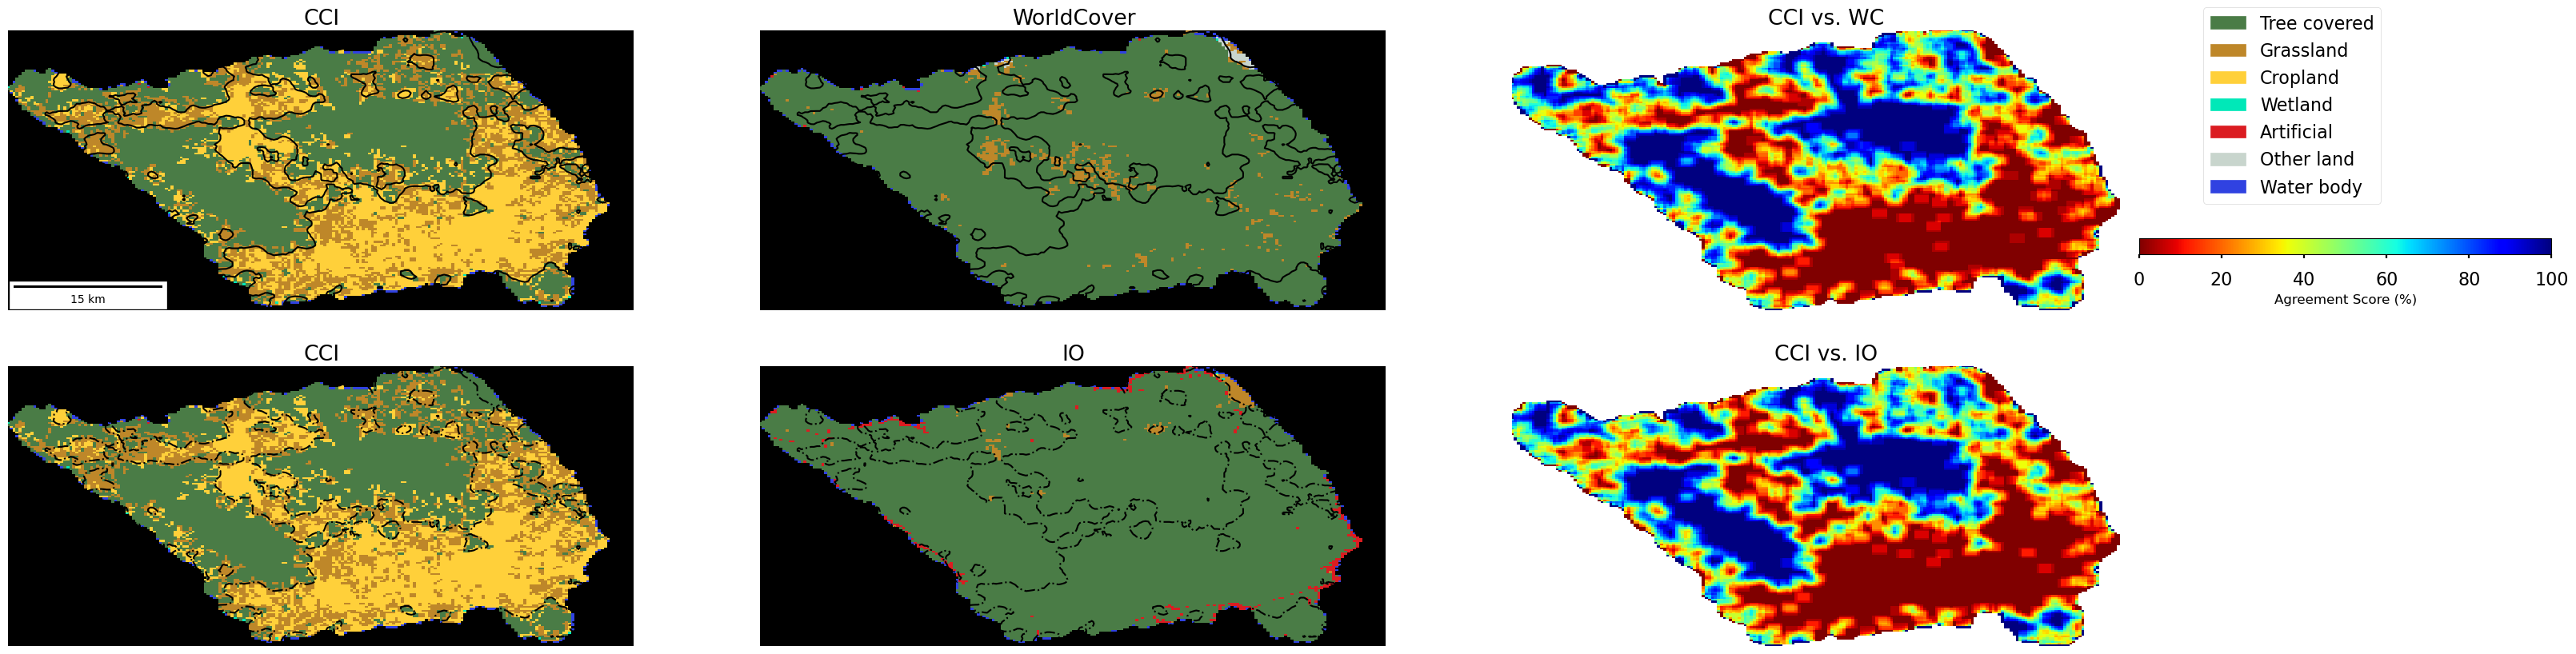

In [19]:
xy_ratio = cci_da['esa_cci_lc'].shape[1]/cci_da['esa_cci_lc'].shape[0]
fig, axes = plt.subplots(2, 3, figsize=(xy_ratio*5*4, 10), gridspec_kw={'wspace':0.2, 'hspace':0.2})

# CCI
cci_da['esa_cci_lc'].plot(ax=axes[0, 0], cmap=standard_cmap, norm=standard_norm, add_colorbar=False)
axes[0, 0].set_title('CCI')
# Add scale bar
scalebar = ScaleBar(1, units="m", location='lower left', length_fraction=0.25)
axes[0, 0].add_artist(scalebar)
# WorldCover
wc_300m['esa_worldcover'].plot(ax=axes[0, 1], cmap=standard_cmap, norm=standard_norm, add_colorbar=False)
axes[0, 1].set_title('WorldCover')

# CCI vs WorldCover agreement
local_agree_wc.plot(ax=axes[0, 2], cmap='jet_r', vmin=0, vmax=100, add_colorbar=False)
axes[0, 2].set_title('CCI vs. WC')

# CCI
cci_da['esa_cci_lc'].plot(ax=axes[1, 0], cmap=standard_cmap, norm=standard_norm, add_colorbar=False)
axes[1, 0].set_title('CCI')
# IO
io_300m['io_lulc'].plot(ax=axes[1, 1], cmap=standard_cmap, norm=standard_norm, add_colorbar=False)
axes[1, 1].set_title('IO')
# CCI vs IO agreement
im = local_agree_io.plot(ax=axes[1, 2], cmap='jet_r', vmin=0, vmax=100, add_colorbar=False)
axes[1, 2].set_title('CCI vs. IO')

# legend
handles = [mpatches.Patch(color=class_colors[i], label=standard_legend[i]) for i in class_ids[1:]]
fig.legend(handles=handles, bbox_to_anchor=(0.92, 0.92), loc='upper left')
plt.tight_layout()

# Overlay contours of agreements at 30% level
levels = [30]
contours = axes[0, 0].contour(local_agree_wc.x, local_agree_wc.y, local_agree_wc,
    levels=levels, colors=['black'], linewidths=1.5)
contours = axes[0, 1].contour(local_agree_wc.x, local_agree_wc.y, local_agree_wc,
    levels=levels, colors=['black'], linewidths=1.5)

contours = axes[1, 0].contour(local_agree_io.x, local_agree_io.y, local_agree_io,
    levels=levels, colors=['black'], linewidths=1.5, linestyles='dashdot')
contours = axes[1, 1].contour(local_agree_io.x, local_agree_io.y, local_agree_io,
    levels=levels, colors=['black'], linewidths=1.5, linestyles='dashdot')

if country == list_countries()[0] or country == list_countries()[5] or country == list_countries()[25]:
    for i in range(0,3):
        axes[0, i].set_xlim(x_min, x_max)
        axes[1, i].set_xlim(x_min, x_max)
        axes[0, i].set_ylim(y_min, y_max)
        axes[1, i].set_ylim(y_min, y_max)
for i in range(2):
    for j in range(3):
        axes[i, j].axis('off')

# Create a colorbar
cax = fig.add_axes([0.9, 0.6, 0.15, 0.02])  # x0, y0, width, height
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label('Agreement Score (%)', fontsize=12)
# plt.savefig(f"../output/{country}_300m_comparison.png", dpi=300, bbox_inches='tight')

# Sankey Diagram to show transition from CCI to two others

In [21]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [22]:
# Make Sankey diagram from CCI transition to WorldCover and IO
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "sankey"}, {"type": "sankey"}]])

# From CCI -> WorldCover
source = cci_da['esa_cci_lc'].values.flatten()
target = wc_300m['esa_worldcover'].values.flatten()
agree_mask = (local_agree_wc.values.flatten() < 30)
params = load_sankey_params(source, target, mask = agree_mask & (source!= 0) & (target != 0) )
fig.add_trace(go.Sankey(
    arrangement="perpendicular",
    node=dict(pad=10, thickness=50, label=params[0], color = params[1], x=[0, 0.5, 1.0, 0, 1]),
    link=dict(source=params[2], target=params[3], value=params[4], color=params[5]) ), row=1, col=1
)

# From CCI -> IO LULC
target = io_300m['io_lulc'].values.flatten()
agree_mask = (local_agree_io.values.flatten() < 30)
params = load_sankey_params(source, target, mask = agree_mask & (source!= 0) & (target != 0) )
fig.add_trace(go.Sankey(
    arrangement="perpendicular",
    node=dict(pad=10, thickness=50, label=params[0], color = params[1], x=[0, 0.5, 1.0, 0, 1]),
    link=dict(source=params[2], target=params[3], value=params[4], color=params[5]) ), row=1, col=2
)

fig.update_layout(
    title=f"{country} CCI -> WorldCover and CCI -> IO",
    font_size=12, width=900, height=600
)
fig.show()
# fig.write_html(f"../output/{country}_Sankey_Under30.html")

# Area per class across three products

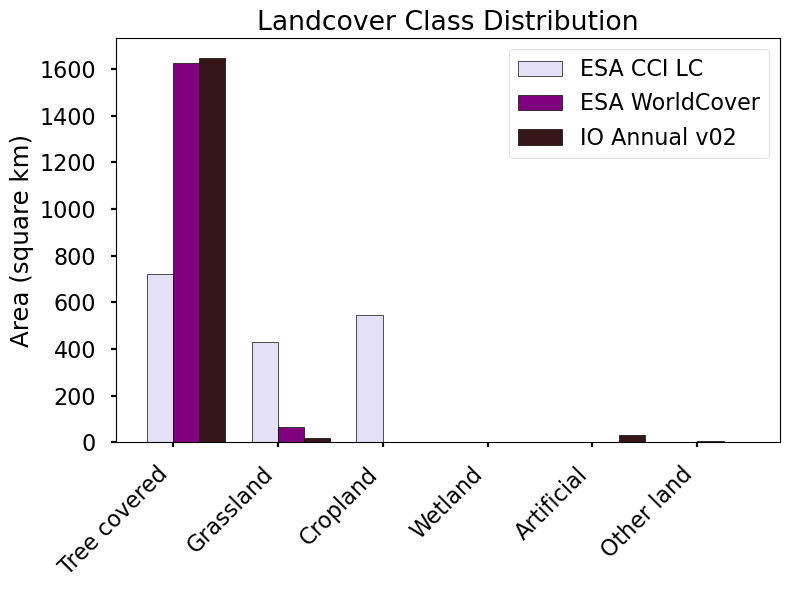

In [ ]:
classes = np.arange(1, len(standard_legend)-1) # Excluding No data , water body
xticks = [standard_legend[i] for i in classes]
width = 0.25

cci_counts = np.array([(cci_da["esa_cci_lc"].values.flatten() == i).sum() for i in classes])
worldcover_counts = np.array([(wc_300m["esa_worldcover"].values.flatten() == i).sum() for i in classes])
io_counts = np.array([(io_300m["io_lulc"].values.flatten() == i).sum() for i in classes])

fig, ax = plt.subplots(figsize=(8, 6)) # 300 m X 300 m = 0.09 square km
ax.bar(classes - width/2, cci_counts*0.09, width, label='ESA CCI LC', color='#E4E0F6', edgecolor='black')
ax.bar(classes + width/2, worldcover_counts*0.09, width, label='ESA WorldCover', color='purple', edgecolor='black')
ax.bar(classes + width*1.5, io_counts*0.09, width, label='IO Annual v02', color='#361719', edgecolor='black')
ax.set_xticks(classes)
ax.set_xticklabels(xticks, rotation=45, ha='right')
ax.set_ylabel('Area (square km)')
ax.set_title('Landcover Class Distribution')
ax.legend()

plt.tight_layout()
# plt.savefig('../output/Landcover_'+str(country)+'_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Agreement score distribution per class

Text(0.5, 1.0, 'Samoa CCI - WorldCover')

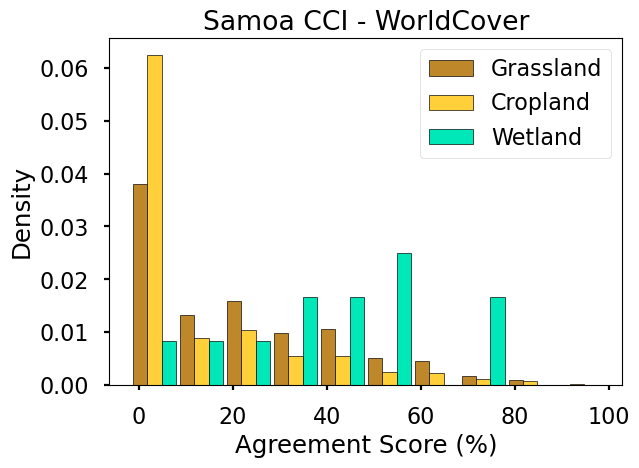

In [28]:
plt.figure(figsize=(6.5, 4.5))
bin_edges = np.linspace(0, 100, 11)
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 3
width = np.diff(bin_edges)[0]/1.3

for cls in [2, 3, 4]: # We look at Grassland, Cropland, Wetland
        wc_vals = local_agree_wc.where(cci_da["esa_cci_lc"] == cls).values.flatten()
        wc_vals = wc_vals[~np.isnan(wc_vals)]
        wc_density, _ = np.histogram(wc_vals, bins=bin_edges, density=True)
        plt.bar(bin_centers + width * 0.4 * (cls-3), wc_density, width * 0.4,
                color=class_colors[cls], edgecolor="black", label=standard_legend[cls])

plt.xlabel("Agreement Score (%)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.title(f"{country} CCI - WorldCover")
# plt.savefig(f"../output/{country}_AS_Distribution_WC.png", dpi=200, bbox_inches='tight')

# Relationship between Agreement Score and Heterogeneity 

In [31]:
from scipy.ndimage import generic_filter
import seaborn as sns

We use a moving 5 x 5 window, same as the calculation of agreement

In [30]:
size = 5
footprint = np.ones((size, size))
hetero_cci = generic_filter(
    cci_da['esa_cci_lc'].fillna(0).values,
    function=heterogeneity_func, footprint=footprint,
    mode="nearest"
)

Box plot showing trend of agreement score vs. heterogeneity.  
25% and 75% are the box boundary.  
50% (median) is the black line 

Text(0.5, 1.0, 'Samoa CCI - WorldCover')

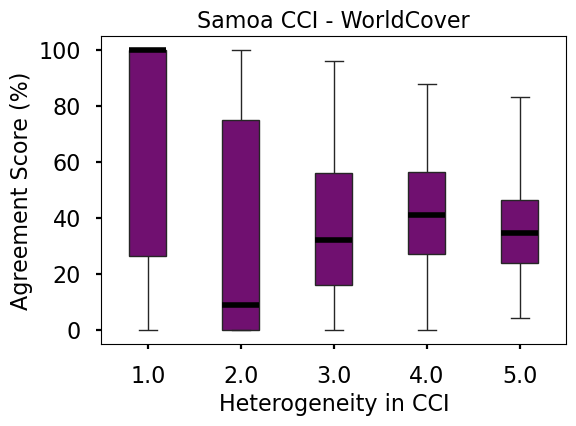

In [32]:
plt.figure(figsize=(6,4))
df = pd.DataFrame({
    "hetero": hetero_cci.flatten(),
    "agreement": local_agree_wc.values.flatten()
}).dropna()
sns.boxplot(data=df, x="hetero", y="agreement", color="purple", 
            whis=(0,100), width=0.4, medianprops={"color":"k", "linewidth":4})
plt.xlabel("Heterogeneity in CCI", fontsize=16)
plt.ylabel("Agreement Score (%)", fontsize=16)
plt.title(f"{country} CCI - WorldCover", fontsize=16)
# plt.savefig(f"../output/{country}_Agreement_vs_Heterogeneity.png", dpi=200, bbox_inches='tight')